In [1]:
import pandas as pd
import numpy as np
from sklearn import cross_validation, metrics
from sklearn.model_selection import GridSearchCV

#模型
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier


import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

/Library/Python/2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# 读取数据

In [2]:

train_url="/Users/leidelong/competition/Porto_Seguro_Safe_Driver_Prediction/train.csv"
train_raw=pd.read_csv(train_url)

test_url="/Users/leidelong/competition/Porto_Seguro_Safe_Driver_Prediction/test.csv"
test_raw=pd.read_csv(test_url)


# 数据探查

In [3]:
print "train shape:",train_raw.shape
print "test shape:",test_raw.shape
print "train columns:",train_raw.columns
print "test columns:",test_raw.columns


train shape: (595212, 59)
test shape: (892816, 58)
train columns: Index([u'id', u'target', u'ps_ind_01', u'ps_ind_02_cat', u'ps_ind_03',
       u'ps_ind_04_cat', u'ps_ind_05_cat', u'ps_ind_06_bin', u'ps_ind_07_bin',
       u'ps_ind_08_bin', u'ps_ind_09_bin', u'ps_ind_10_bin', u'ps_ind_11_bin',
       u'ps_ind_12_bin', u'ps_ind_13_bin', u'ps_ind_14', u'ps_ind_15',
       u'ps_ind_16_bin', u'ps_ind_17_bin', u'ps_ind_18_bin', u'ps_reg_01',
       u'ps_reg_02', u'ps_reg_03', u'ps_car_01_cat', u'ps_car_02_cat',
       u'ps_car_03_cat', u'ps_car_04_cat', u'ps_car_05_cat', u'ps_car_06_cat',
       u'ps_car_07_cat', u'ps_car_08_cat', u'ps_car_09_cat', u'ps_car_10_cat',
       u'ps_car_11_cat', u'ps_car_11', u'ps_car_12', u'ps_car_13',
       u'ps_car_14', u'ps_car_15', u'ps_calc_01', u'ps_calc_02', u'ps_calc_03',
       u'ps_calc_04', u'ps_calc_05', u'ps_calc_06', u'ps_calc_07',
       u'ps_calc_08', u'ps_calc_09', u'ps_calc_10', u'ps_calc_11',
       u'ps_calc_12', u'ps_calc_13', u'ps_calc_14

In [4]:
#拆分数据集
from sklearn.cross_validation import train_test_split  

#标注正样本和负样本
train_pos=train_raw[train_raw['target']==1]
print train_pos['target'].value_counts()
train_neg=train_raw[train_raw['target']==0]
print train_neg['target'].value_counts()

#df转narray
train_pos=np.array(train_pos)
train_neg=np.array(train_neg)
#数据集拆分
train_pos_new,validation_pos_new = train_test_split(train_pos,  
                                                   test_size = 0.2,  
                                                   random_state = 0)  
train_neg_new,validation_neg_new = train_test_split(train_neg,  
                                                   test_size = 0.2,  
                                                   random_state = 0)  
#数据集拼接
train_new=np.concatenate([train_pos_new,train_neg_new],axis=0) #在纵轴上合并

validation_new=np.concatenate([validation_pos_new,validation_neg_new],axis=0) #在纵轴上合并


#修改train、validation、test
train_temp=pd.DataFrame(train_new)
train_temp.columns=train_raw.columns
train=train_temp

validation_temp=pd.DataFrame(validation_new)
validation_temp.columns=train_raw.columns
validation=validation_temp

test=test_raw


1    21694
Name: target, dtype: int64
0    573518
Name: target, dtype: int64


In [5]:

train['tag']='train'
validation['tag']='validation'
test['tag']='test'

test.insert(1,'target',2)

print train.shape
print validation.shape
print test.shape




(476169, 60)
(119043, 60)
(892816, 60)


In [6]:
alldata=pd.concat([train,validation,test]) #在纵轴上合并
print alldata.shape

(1488028, 60)


In [7]:
print alldata.columns

Index([u'id', u'target', u'ps_ind_01', u'ps_ind_02_cat', u'ps_ind_03',
       u'ps_ind_04_cat', u'ps_ind_05_cat', u'ps_ind_06_bin', u'ps_ind_07_bin',
       u'ps_ind_08_bin', u'ps_ind_09_bin', u'ps_ind_10_bin', u'ps_ind_11_bin',
       u'ps_ind_12_bin', u'ps_ind_13_bin', u'ps_ind_14', u'ps_ind_15',
       u'ps_ind_16_bin', u'ps_ind_17_bin', u'ps_ind_18_bin', u'ps_reg_01',
       u'ps_reg_02', u'ps_reg_03', u'ps_car_01_cat', u'ps_car_02_cat',
       u'ps_car_03_cat', u'ps_car_04_cat', u'ps_car_05_cat', u'ps_car_06_cat',
       u'ps_car_07_cat', u'ps_car_08_cat', u'ps_car_09_cat', u'ps_car_10_cat',
       u'ps_car_11_cat', u'ps_car_11', u'ps_car_12', u'ps_car_13',
       u'ps_car_14', u'ps_car_15', u'ps_calc_01', u'ps_calc_02', u'ps_calc_03',
       u'ps_calc_04', u'ps_calc_05', u'ps_calc_06', u'ps_calc_07',
       u'ps_calc_08', u'ps_calc_09', u'ps_calc_10', u'ps_calc_11',
       u'ps_calc_12', u'ps_calc_13', u'ps_calc_14', u'ps_calc_15_bin',
       u'ps_calc_16_bin', u'ps_calc_17_bin',

In [8]:
#数据清洗
df_alldata=pd.DataFrame(alldata)
df_alldata.columns=test.columns
print df_alldata['tag'].value_counts()


df_alldata_nan = df_alldata.replace(-1, np.nan)

target='target'
IDcol = 'id'
tag='tag'
predictors = [x for x in df_alldata_nan.columns if x not in [target, IDcol,tag]]


test          892816
train         476169
validation    119043
Name: tag, dtype: int64


In [9]:
print df_alldata['target'].value_counts()


2.0    892816
0.0    573518
1.0     21694
Name: target, dtype: int64


In [10]:
print '空值占比：'
line_count=df_alldata_nan['target'].count()
for i in predictors :
    nan_cnt=  line_count - df_alldata_nan[i][df_alldata_nan[i].notnull()].count()
    if nan_cnt!=0:
        print i,": {:.5f}% ".format(nan_cnt/(line_count*1.0)*100 )

空值占比：
ps_ind_02_cat : 0.03515% 
ps_ind_04_cat : 0.01532% 
ps_ind_05_cat : 0.97572% 
ps_reg_03 : 18.10826% 
ps_car_01_cat : 0.01794% 
ps_car_02_cat : 0.00067% 
ps_car_03_cat : 69.09426% 
ps_car_05_cat : 44.81838% 
ps_car_07_cat : 1.93679% 
ps_car_09_cat : 0.09718% 
ps_car_11 : 0.00040% 
ps_car_12 : 0.00007% 
ps_car_14 : 7.15208% 


In [11]:
print df_alldata_nan.columns

Index([u'id', u'target', u'ps_ind_01', u'ps_ind_02_cat', u'ps_ind_03',
       u'ps_ind_04_cat', u'ps_ind_05_cat', u'ps_ind_06_bin', u'ps_ind_07_bin',
       u'ps_ind_08_bin', u'ps_ind_09_bin', u'ps_ind_10_bin', u'ps_ind_11_bin',
       u'ps_ind_12_bin', u'ps_ind_13_bin', u'ps_ind_14', u'ps_ind_15',
       u'ps_ind_16_bin', u'ps_ind_17_bin', u'ps_ind_18_bin', u'ps_reg_01',
       u'ps_reg_02', u'ps_reg_03', u'ps_car_01_cat', u'ps_car_02_cat',
       u'ps_car_03_cat', u'ps_car_04_cat', u'ps_car_05_cat', u'ps_car_06_cat',
       u'ps_car_07_cat', u'ps_car_08_cat', u'ps_car_09_cat', u'ps_car_10_cat',
       u'ps_car_11_cat', u'ps_car_11', u'ps_car_12', u'ps_car_13',
       u'ps_car_14', u'ps_car_15', u'ps_calc_01', u'ps_calc_02', u'ps_calc_03',
       u'ps_calc_04', u'ps_calc_05', u'ps_calc_06', u'ps_calc_07',
       u'ps_calc_08', u'ps_calc_09', u'ps_calc_10', u'ps_calc_11',
       u'ps_calc_12', u'ps_calc_13', u'ps_calc_14', u'ps_calc_15_bin',
       u'ps_calc_16_bin', u'ps_calc_17_bin',

In [12]:
df_alldata_nan.isnull().any()

id                False
target            False
ps_ind_01         False
ps_ind_02_cat      True
ps_ind_03         False
ps_ind_04_cat      True
ps_ind_05_cat      True
ps_ind_06_bin     False
ps_ind_07_bin     False
ps_ind_08_bin     False
ps_ind_09_bin     False
ps_ind_10_bin     False
ps_ind_11_bin     False
ps_ind_12_bin     False
ps_ind_13_bin     False
ps_ind_14         False
ps_ind_15         False
ps_ind_16_bin     False
ps_ind_17_bin     False
ps_ind_18_bin     False
ps_reg_01         False
ps_reg_02         False
ps_reg_03          True
ps_car_01_cat      True
ps_car_02_cat      True
ps_car_03_cat      True
ps_car_04_cat     False
ps_car_05_cat      True
ps_car_06_cat     False
ps_car_07_cat      True
ps_car_08_cat     False
ps_car_09_cat      True
ps_car_10_cat     False
ps_car_11_cat     False
ps_car_11          True
ps_car_12          True
ps_car_13         False
ps_car_14          True
ps_car_15         False
ps_calc_01        False
ps_calc_02        False
ps_calc_03      

In [13]:

print '各个值出现的频率：'
for i in predictors :
    print i," : ",df_alldata_nan[i].value_counts()
    

各个值出现的频率：
ps_ind_01  :  0.0    469109
1.0    359925
2.0    205761
5.0    153663
3.0    127634
4.0     84045
6.0     44486
7.0     43405
Name: ps_ind_01, dtype: int64
ps_ind_02_cat  :  1.0    1079327
2.0     309747
3.0      70172
4.0      28259
Name: ps_ind_02_cat, dtype: int64
ps_ind_03  :  2.0     240652
3.0     204836
1.0     170922
4.0     167980
5.0     157043
6.0     150987
7.0     130452
8.0      98528
9.0      63551
0.0      38878
10.0     35863
11.0     28336
Name: ps_ind_03, dtype: int64
ps_ind_04_cat  :  0.0    866864
1.0    620936
Name: ps_ind_04_cat, dtype: int64
ps_ind_05_cat  :  0.0    1319412
6.0      51877
4.0      45706
3.0      20754
1.0      20737
2.0      10707
5.0       4316
Name: ps_ind_05_cat, dtype: int64
ps_ind_06_bin  :  0.0    902572
1.0    585456
Name: ps_ind_06_bin, dtype: int64
ps_ind_07_bin  :  0.0    1105415
1.0     382613
Name: ps_ind_07_bin, dtype: int64
ps_ind_08_bin  :  0.0    1244343
1.0     243685
Name: ps_ind_08_bin, dtype: int64
ps_ind_09_bin  : 

In [14]:
ind_vars = [] 
reg_vars = []
car_vars = []
calc_vars = []
rest_vars = []

bin_vars = []
cat_vars = []
num_ord_vars = []

for f in df_alldata_nan.columns:
    if 'ind' in f:
        ind_vars.append(f)
    elif 'reg' in f:
        reg_vars.append(f)
    elif 'car' in f:
        car_vars.append(f)
    elif 'calc' in f:
        calc_vars.append(f)
    else:
        rest_vars.append(f)
        
    if 'bin' in f:
        bin_vars.append(f)
    elif 'cat' in f:
        cat_vars.append(f)
    else:
        num_ord_vars.append(f)
        
print('There are {} variables of grouping ind'.format(len(ind_vars)))
print('There are {} variables of grouping reg'.format(len(reg_vars)))
print('There are {} variables of grouping car'.format(len(car_vars)))
print('There are {} variables of grouping calc'.format(len(calc_vars)))
print('\n')
print('There are {} binary variables'.format(len(bin_vars)))
print('There are {} categorical variables'.format(len(cat_vars)))
print('There are {} ordinal/numerical variables'.format(len(num_ord_vars)))

There are 18 variables of grouping ind
There are 3 variables of grouping reg
There are 16 variables of grouping car
There are 20 variables of grouping calc


There are 17 binary variables
There are 14 categorical variables
There are 29 ordinal/numerical variables


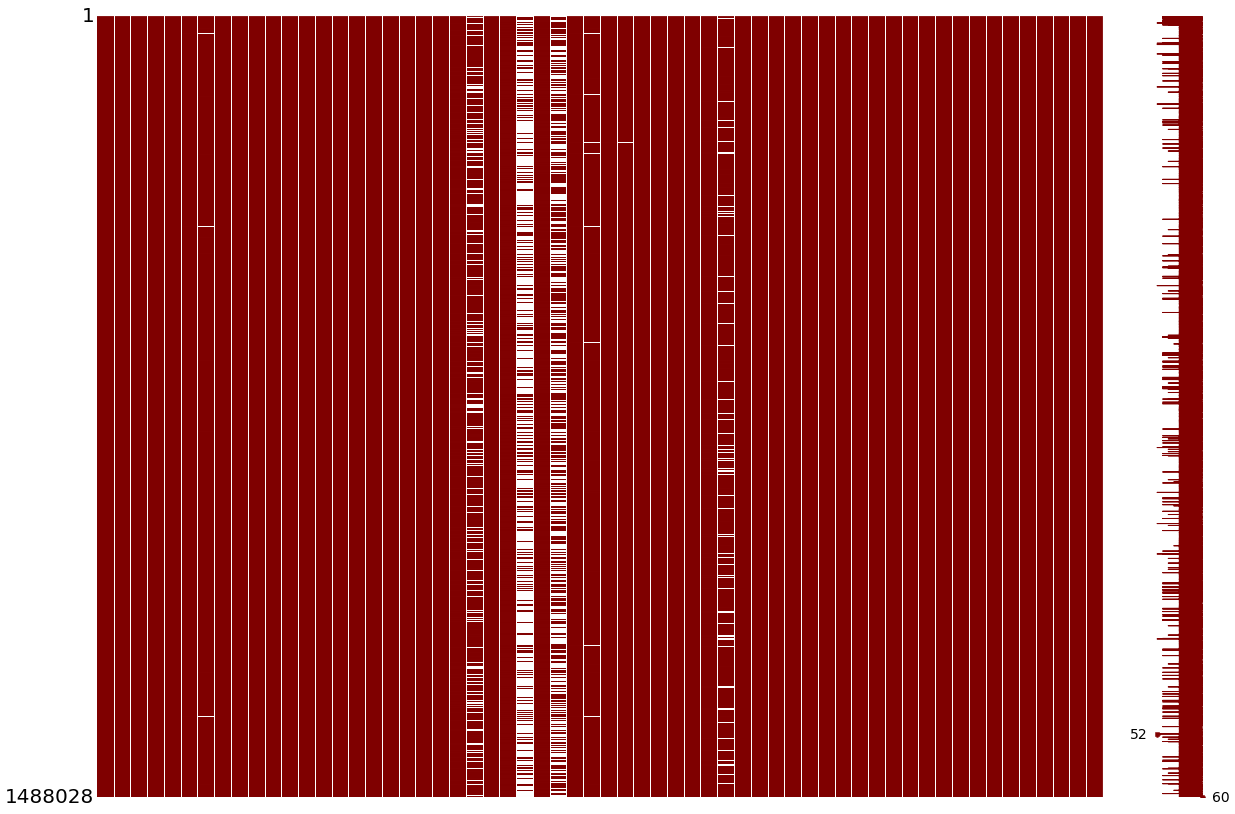

In [15]:
import missingno as msno

msno.matrix(df=df_alldata_nan.iloc[:,:60], figsize=(20,14), color=(0.5,0,0))

In [16]:
target='target'
IDcol = 'id'
tag='tag'

df_alldata_nan['tag'].value_counts()

test          892816
train         476169
validation    119043
Name: tag, dtype: int64

In [34]:
#评估方法
def gini(actual, pred, cmpcol = 0, sortcol = 1):
     assert( len(actual) == len(pred) )
     all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
     all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
     totalLosses = all[:,0].sum()
     giniSum = all[:,0].cumsum().sum() / totalLosses
 
     giniSum -= (len(actual) + 1) / 2.
     return giniSum / len(actual)

def gini_normalized(a, p):
        return gini(a, p) / gini(a, a)
    

# xgboost

In [35]:
#模型训练
def xgboostModelFit(alg, dtrain, dtest, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        xgtest = xgb.DMatrix(dtest[predictors].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #模型训练
    alg.fit(dtrain[predictors], dtrain['target'],eval_metric='auc')
        
    #模型预测-训练集
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #输出模型效果-训练集:
    print "\nModel Report- train data"
    print "Accuracy（Train） : %.4g" % metrics.accuracy_score(dtrain['target'].values, dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['target'], dtrain_predprob)
    print "GINI Score (Train): %f" % gini_normalized(dtrain['target'], dtrain_predprob)
    
    #模型预测-测试集
    dtest['prediction'] = alg.predict(dtest[predictors])
    dtest['predprob'] = alg.predict_proba(dtest[predictors])[:,1]
    #输出模型效果-测试集
    print "\nModel Report- test data"
    print "Accuracy（Test） : %.4g" % metrics.accuracy_score(dtest['target'].values,dtest['prediction'])
    print 'AUC Score (Test): %f' % metrics.roc_auc_score(dtest['target'], dtest['predprob'])
    print "GINI Score (Test): %f" % gini_normalized(dtest['target'], dtest['predprob'])
    
    return alg


In [37]:
predictors = [x for x in df_alldata_nan.columns if x not in [target, IDcol,tag]]
train=df_alldata_nan[df_alldata_nan['tag']=='train']
validation=df_alldata_nan[df_alldata_nan['tag']=='validation']
test=df_alldata_nan[df_alldata_nan['tag']=='test']


xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=100,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=26.4, #解决样本不均衡的问题
        seed=27)

In [38]:
alg=xgboostModelFit(xgb1, train, validation, predictors)


Model Report- train data
Accuracy（Train） : 0.658
AUC Score (Train): 0.692201
GINI Score (Train): 0.384402


/Library/Python/2.7/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Model Report- test data
Accuracy（Test） : 0.6531
AUC Score (Test): 0.639788
GINI Score (Test): 0.279576


/Library/Python/2.7/site-packages/ipykernel/__main__.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


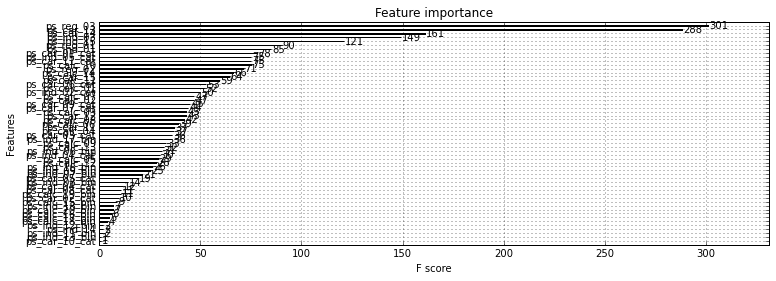

In [39]:
xgb.plot_importance(alg,height=0.1)

# 以下是最终测试数据效果

In [40]:
#最终测试集
X_test_raw= test[predictors]
y_raw_test_pred = alg.predict(X_test_raw)
y_raw_test_predprob=alg.predict_proba(X_test_raw)[:,1]

In [41]:
y_raw_test_predprob

array([ 0.40999734,  0.46561918,  0.44993386, ...,  0.49927339,
        0.43101752,  0.43424752], dtype=float32)

In [42]:
y_raw_test_predprob.shape

(892816,)

In [43]:
test_raw.head(10)

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin,tag
0,0,2,0,1,8,1,0,0,1,0,...,1,1,12,0,1,1,0,0,1,test
1,1,2,4,2,5,1,0,0,0,0,...,0,3,10,0,0,1,1,0,1,test
2,2,2,5,1,3,0,0,0,0,0,...,0,2,4,0,0,0,0,0,0,test
3,3,2,0,1,6,0,0,1,0,0,...,1,0,5,1,0,1,0,0,0,test
4,4,2,5,1,7,0,0,0,0,0,...,0,0,4,0,1,1,0,0,1,test
5,5,2,0,1,6,0,0,1,0,0,...,1,4,9,1,0,1,0,1,0,test
6,6,2,0,1,3,0,0,0,1,0,...,0,4,6,1,1,0,0,0,0,test
7,8,2,0,1,0,0,0,1,0,0,...,1,4,9,0,1,0,0,0,0,test
8,10,2,0,1,7,0,0,0,1,0,...,1,4,6,0,0,1,0,0,0,test
9,11,2,1,1,6,0,0,0,0,0,...,1,6,10,0,1,1,0,0,0,test


In [44]:
X_ID = test_raw['id']
X_ID=pd.DataFrame(X_ID)
df_y_test_predprob=pd.DataFrame(y_raw_test_predprob)
print df_y_test_predprob.shape,X_ID.shape

(892816, 1) (892816, 1)


In [45]:
df_y_test_predprob.head(10)

,0
0,0.409997
1,0.465619
2,0.449934
3,0.298784
4,0.476278
5,0.535665
6,0.249865
7,0.401130
8,0.643541
9,0.607584


In [46]:
result=pd.concat([X_ID,df_y_test_predprob],axis=1)
result.columns = ['id', 'target']
result.shape

(892816, 2)

In [47]:
result.head(10)

,id,target
0,0,0.409997
1,1,0.465619
2,2,0.449934
3,3,0.298784
4,4,0.476278
5,5,0.535665
6,6,0.249865
7,8,0.401130
8,10,0.643541
9,11,0.607584


In [48]:
result.to_csv("/Users/leidelong/competition/Porto_Seguro_Safe_Driver_Prediction/test_result.csv",index=False)